In [1]:
import OpenEXR
import Imath
import array
from PIL import Image, ImageDraw
import numpy as np
import json
import math
from matplotlib import pyplot as plt
FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
%matplotlib inline

<h1> Load Data </h1>

In [13]:
data_dir_base = '/home/ubuntu/thomas/old_data'
idx = 20
# get annotation data
annotation_file_name = 'annot_{}.json'.format(idx)
annotation_file_path = '{}/{}/{}'.format(data_dir_base, 'annotations', annotation_file_name)
annotation_data = json.load(open(annotation_file_path, 'rb'))

# get segmentation data
segmentation_file_name = 'mask_{}.png'.format(idx)
segmentation_file_path = '{}/{}/{}'.format(data_dir_base, 'mask', segmentation_file_name)
mask = np.array(Image.open(segmentation_file_path))

# get depth map data
depth_map_file_name = 'test_{}_28.exr'.format(idx)
depth_map_file_path = '{}/{}/{}'.format(data_dir_base, 'dm', depth_map_file_name)
pixel_data = OpenEXR.InputFile(depth_map_file_path)
(R,G,B) = [array.array('f', pixel_data.channel(chan, FLOAT)).tolist() for chan in ("R", "G", "B") ]
depth_map = np.reshape(np.array(R), mask.shape)

<h1> Display segmentation mask </h1>

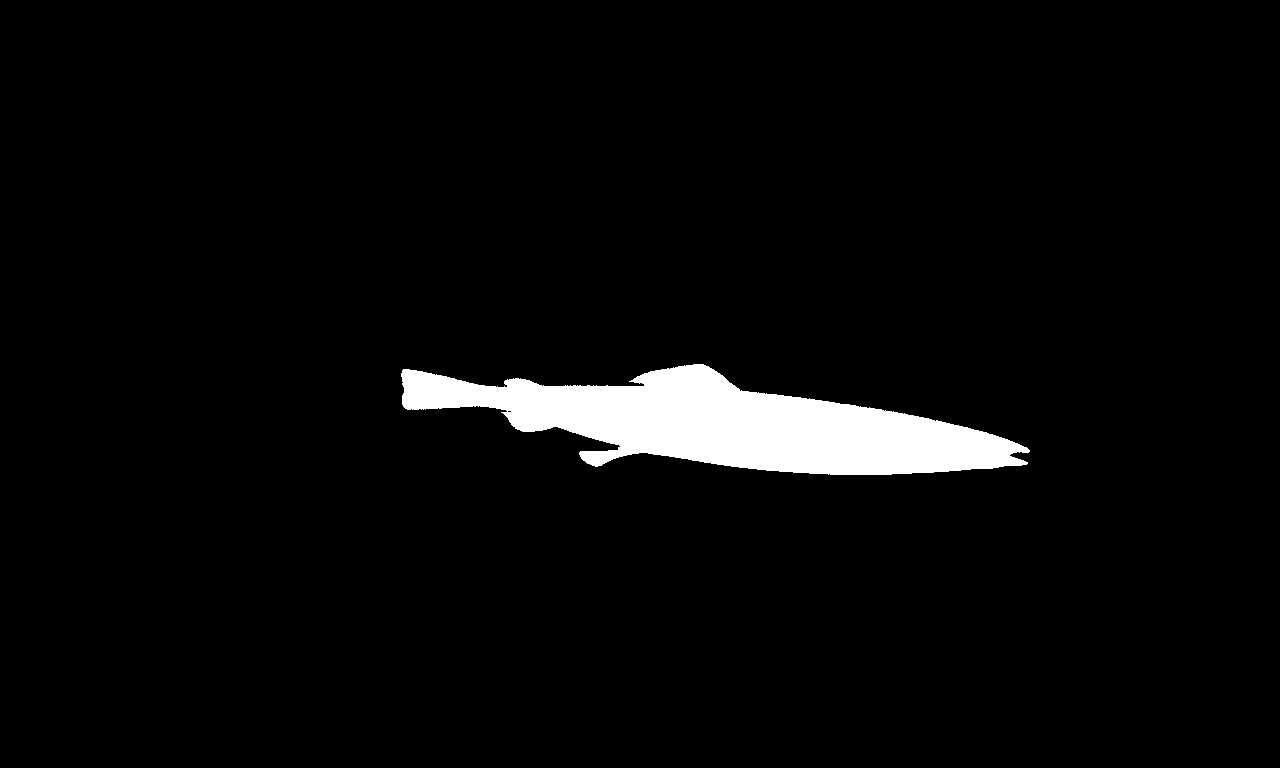

In [14]:
image = Image.fromarray(mask, 'L')
draw = ImageDraw.Draw(image)
image

<h1> Display depth map </h1>

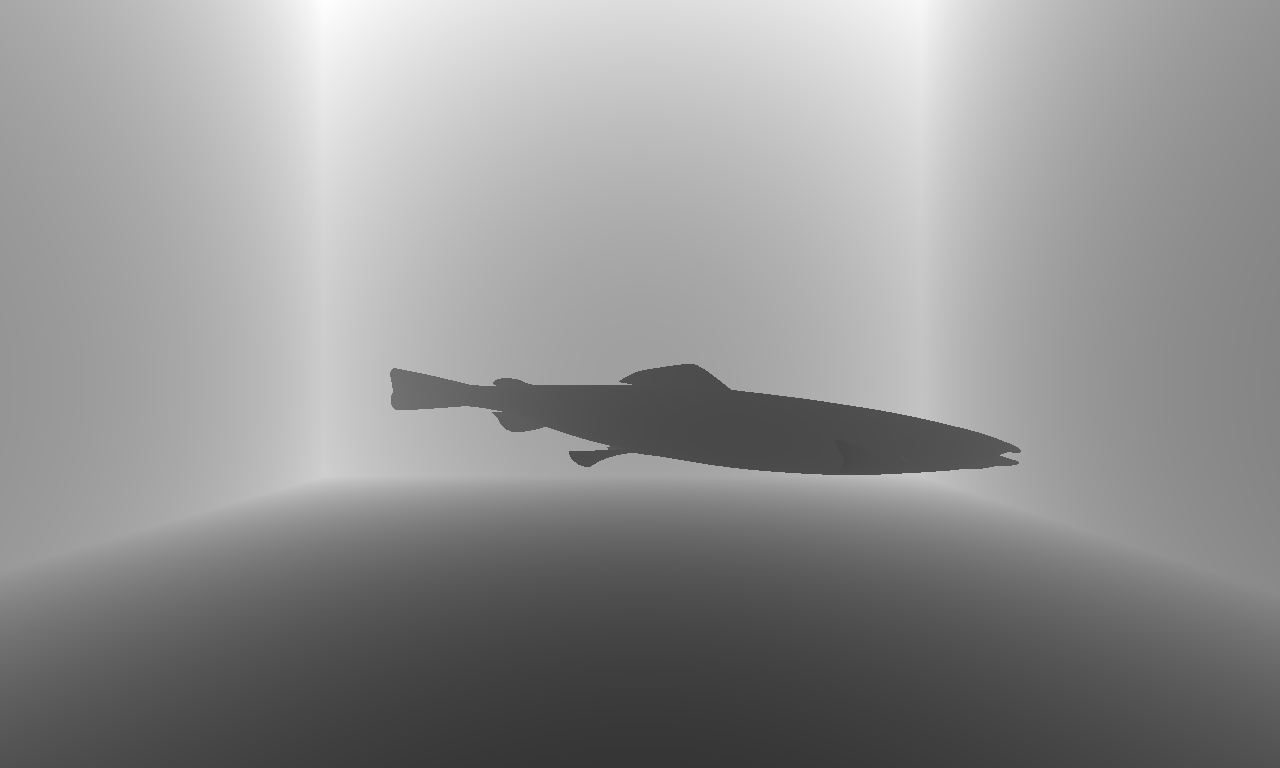

In [15]:
im = Image.fromarray((depth_map * (255 / depth_map.max())).astype('uint8'), 'L')
im

<h1> Get depth distribution across all points on the visible surface of the fish </h1>

In [201]:
hist_counts, hist_bucket_endpoints = np.histogram(depth_map[np.where(mask > 0)])
print hist_counts, hist_bucket_endpoints
cutoff_idx = np.where(hist_counts == 0)[0][0]
cutoff = hist_bucket_endpoints[cutoff_idx]
print 'Mean depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].mean())
print 'Maximum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].max())
print 'Minimum depth value: {}'.format(depth_map[np.where((depth_map < cutoff) & (mask > 0)) ].min())

[21465   890     0     0     0     0     0     0   557  1031] [ 83.85470581 108.80643616 133.7581665  158.70989685 183.6616272
 208.61335754 233.56508789 258.51681824 283.46854858 308.42027893
 333.37200928]
Mean depth value: 91.6301279643
Maximum depth value: 117.418777466
Minimum depth value: 83.8547058105


<h1> Get pixel coordinates for determining length, width, and breadth </h1>

In [236]:
mask_values = np.where(mask > 0)
x_values = mask_values[1]
y_values = mask_values[0]
adj_y_values = mask.shape[0] - y_values
mask_points = zip(x_values, adj_y_values)

A = np.vstack([x_values, np.ones(len(x_values))]).T
res = np.linalg.lstsq(A,adj_y_values)
m, b = res[0]

# get length endpoints
x_lower = x_values.min()
while x_lower < mask.shape[1]:
    adj_y_lower = int(round(m*x_lower + b))
    y_lower = mask.shape[0] - 1 - adj_y_lower
    if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)): 
        break
    x_lower += 1

x_upper = x_values.max()
while x_upper > 0:
    adj_y_upper = int(round(m*x_upper + b))
    y_upper = mask.shape[0] - 1 - adj_y_upper
    if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
        break
    x_upper -= 1

y_lower = mask.shape[0] - adj_y_lower
y_upper = mask.shape[0] - adj_y_upper
length_endpoint_1 = (x_lower, y_lower)
length_endpoint_2 = (x_upper, y_upper)

# get width endpoints
m = -1 / float(m)
b = adj_y_values.mean() - m*x_values.mean()

adj_y_lower = adj_y_values.min()
while adj_y_lower < mask.shape[0]:
    x_lower = int(round((adj_y_lower - b)/float(m)))
    y_lower = mask.shape[0] - 1 - adj_y_lower
    if ((x_lower, adj_y_lower) in mask_points and (depth_map[y_lower, x_lower] < cutoff)):
        break
    adj_y_lower += 1


adj_y_upper = adj_y_values.max()
while adj_y_upper > 0:
    x_upper = int(round((adj_y_upper - b)/float(m)))
    y_upper = mask.shape[0] - 1 - adj_y_upper
    if ((x_upper, adj_y_upper) in mask_points and (depth_map[y_upper, x_upper] < cutoff)):
        break
    adj_y_upper -= 1

# y_lower = mask.shape[0] - 1 - adj_y_lower
# y_upper = mask.shape[0] - 1 - adj_y_upper
width_endpoint_1 = (x_lower, y_lower)
width_endpoint_2 = (x_upper, y_upper)

# get centroid coordinates
x_centroid = mask_values[1].mean()
y_centroid = mask_values[0].mean()
centroid = (x_centroid, y_centroid)

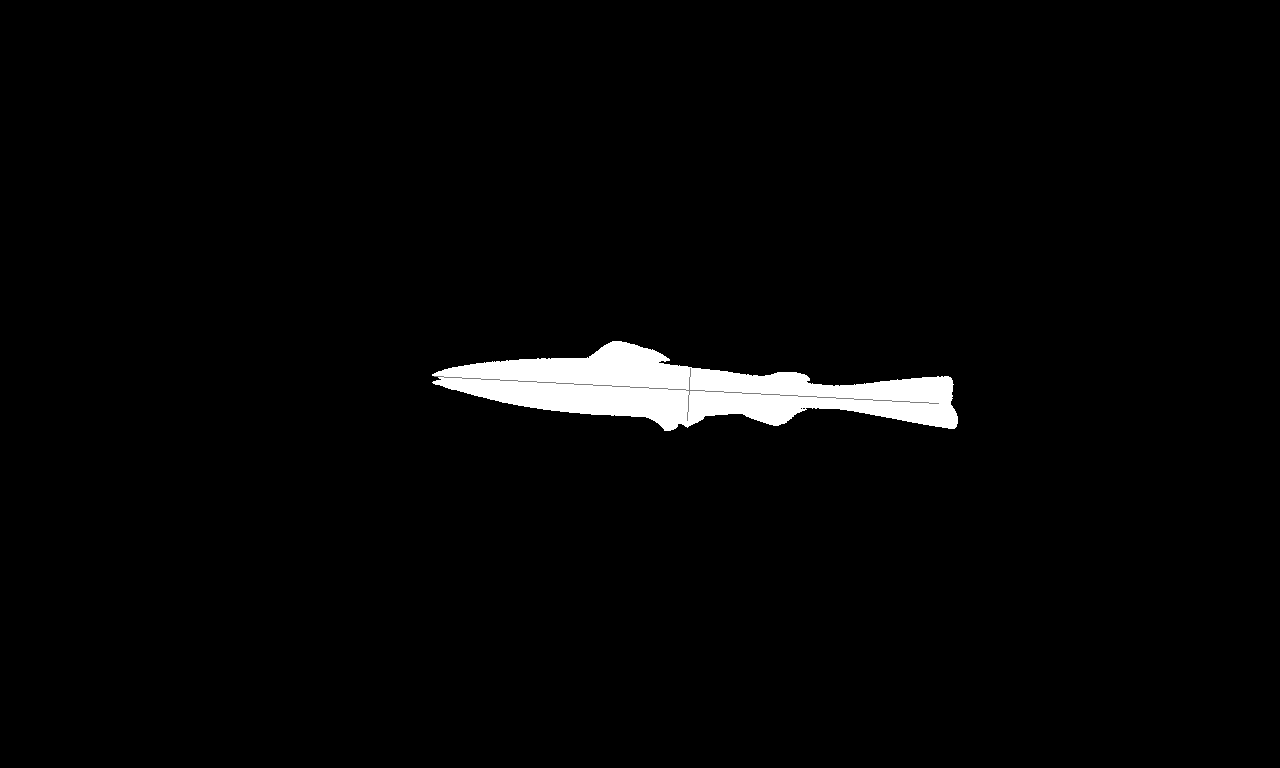

In [226]:
image = Image.fromarray(mask, 'L')
draw = ImageDraw.Draw(image)
draw.line((length_endpoint_1[0], length_endpoint_1[1], length_endpoint_2[0], length_endpoint_2[1]), fill=128)
draw.line((width_endpoint_1[0], width_endpoint_1[1], width_endpoint_2[0], width_endpoint_2[1]), fill=128)
image

In [227]:
width_endpoint_1_world, width_endpoint_2_world

((34.81417147954204, 296.29082110248544, -15.416381785488696),
 (10.777941455687522, 86.22353164550017, 1.818777620647269))

<h1> Get world coordinates of head, tail and fish centroid on visible surface </h1>

In [228]:
focal_length = annotation_data['focal_length_mm'] / 10.0
image_sensor_width = annotation_data['sensor_width_mm'] / 10.0
image_sensor_height = annotation_data['sensor_height_mm'] / 10.0
px_count_width = annotation_data['resolution'][0]
px_count_height = annotation_data['resolution'][0]

In [229]:
def convert_to_world_point(x, y, depth_map, mask):
    image_center_x = mask.shape[1] / 2.0
    image_center_y = mask.shape[0] / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y
    sensor_x = px_x * (image_sensor_width / px_count_width)
    sensor_z = px_z * (image_sensor_height / px_count_height)

    d = depth_map[y, x]
    world_y = d / (math.sqrt(1 + ((sensor_x**2 + sensor_z**2)/(focal_length**2))))
    world_x = (world_y * sensor_x) / focal_length
    world_z = (world_y * sensor_z) / focal_length
    
    return (world_x, world_y, world_z)
    

In [230]:
length_endpoint_1_world = convert_to_world_point(length_endpoint_1[0], length_endpoint_1[1], depth_map, mask)
length_endpoint_2_world = convert_to_world_point(length_endpoint_2[0], length_endpoint_2[1], depth_map, mask)
width_endpoint_1_world = convert_to_world_point(width_endpoint_1[0], width_endpoint_1[1], depth_map, mask)
width_endpoint_2_world = convert_to_world_point(width_endpoint_2[0], width_endpoint_2[1], depth_map, mask)
centroid_world = convert_to_world_point(int(round(centroid[0])), int(round(centroid[1])), depth_map, mask)


116.46849060058594 103.53873254432682
px_x: -206.0, px_z: 8.0, sensor_x: -0.515, world_x: -53.3224472603
92.73426055908203 74.3484397514692
px_x: 298.0, px_z: -19.0, sensor_x: 0.745, world_x: 55.3895876148
97.00350952148438 96.21919338473069
px_x: 47.0, px_z: -36.0, sensor_x: 0.1175, world_x: 11.3057552227
87.27760314941406 86.58205851310845
px_x: 50.0, px_z: 16.0, sensor_x: 0.125, world_x: 10.8227573141
85.04436492919922 84.41039921019699
px_x: 49.0, px_z: -6.0, sensor_x: 0.1225, world_x: 10.3402739032


<h1> Get length and width </h1>

In [231]:
def distance_between_points(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

In [232]:
length = distance_between_points(length_endpoint_1_world, length_endpoint_2_world)
width = distance_between_points(width_endpoint_1_world, width_endpoint_2_world)

In [233]:
length, width

(112.60688461579, 11.815627297543728)

In [234]:
w = distance_between_points((length_endpoint_1[1], length_endpoint_1[0], 0), (length_endpoint_2[1], length_endpoint_2[0], 0))
l = distance_between_points((width_endpoint_1[1], width_endpoint_1[0], 0), (width_endpoint_2[1], width_endpoint_2[0], 0))
print w, l

504.722696141 52.0864665724


In [235]:
annotation_data

{u'camera_position': [0.0, -94.92864227294922, 3.0],
 u'fish_location': [19.677982330322266, 1.3954613208770752, 237.1347198486328],
 u'focal_length_mm': 10.0,
 u'height': 20.06241389362671,
 u'length': 120.37448336176027,
 u'render_samples': 64,
 u'resolution': [1280, 768],
 u'sensor_height_mm': 18.0,
 u'sensor_width_mm': 32.0,
 u'unit': u'centimeters',
 u'unit_system': u'METRIC',
 u'volume': 0.0031516965660060158,
 u'width': 20.06241389362671}